<a href="https://colab.research.google.com/github/castejon777/ANNTemperaturePrediction/blob/main/redneuronalTFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
#!pip install analytics-zoo

!pip install pyspark

#tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('App Name').getOrCreate()

import numpy as np
import pandas as pd
import plotly.express as px
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn import metrics

from datetime import datetime 

from google.colab import drive
drive.mount('/content/drive')


!pip3 install ann_visualizer
from ann_visualizer.visualize import ann_viz;

     |████████████████████████████████| 212.4MB 62kB/s 
     |████████████████████████████████| 204kB 15.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=ce0ba6b2fccb1d07e0b5198a67051c0cf2a1ec6ad5203c3afd0c52283eafec22
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark
Mounted at /content/drive
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-cp37-none-any.whl size=4168 sha256=f00dc5f05da519ff3d52b3a9a10d5a1821cb8af6f26e5791bb8f802eb79e7ae6
  Stored in directory: /root/.cache/pip/wheels/b6/b4/4e/d92f50c9c4f004cf315a0e0fcd455486bd799c50fe80cf1f5d
Successfully built ann-visualizer


In [3]:
#Declaracion de las variables globales necesarias
df = pd.DataFrame()
train = pd.DataFrame()
test = pd.DataFrame()
x_label = pd.DataFrame()
y_label = pd.DataFrame()
x_test = pd.DataFrame()
y_test = pd.DataFrame()
xin_test = pd.DataFrame()
yin_test  = pd.DataFrame()
xout_test = pd.DataFrame()
yout_test = pd.DataFrame()
xret_test = pd.DataFrame()
yret_test = pd.DataFrame()
model = tf.keras.Sequential()
predictions = pd.DataFrame()
times = 0
tempmax = 0

In [4]:
#Se leen las dos bases de datos y se almacenan en variables
data_raw = spark.read.option("multiline", "true").parquet('/content/drive/MyDrive/data/interxion/telemetry').toPandas()
nodes = spark.read.option("multiline", "true").json('/content/drive/MyDrive/data/interxion/location/location.json').toPandas()



In [9]:
#Funcion necesaria para el preproceso previo de los datos
def preparacionDataFrame():
  global df
  formato = "%H:%M"
  #Se unen las dos bases de datos
  df = data_raw.merge(nodes, left_on='macaddress', right_on='macaddress', how='left')
  df['timeID'] = pd.to_datetime(df.timeID)

  #Preparamos los datos de la hora para introducirlos en la red neuronal en función de los minutos del día
  hhmmss = df['timeID']
  horas = hhmmss.dt.hour
  minutos = hhmmss.dt.minute
  hhmmss_min = horas * 60 + minutos 
  minutos = hhmmss_min / (60*24)
  df['time']=  minutos
  df['temperature'] = df['temperature'] / 100
  df['temperature10min'] = df['temperature'].loc[(df.time >= (0.08333333333333333+10/(24*60) ))].copy()
  df[['temperature10min']] = df[['temperature10min']].fillna(value=df[['temperature10min']].mean())

preparacionDataFrame()

In [8]:
#Selecciona el porcentaje deseado de los datos totales del dataframe, de forma aleatoria
#coef: introducir el porcentaje [0, 1] de las instancias que se desean
#seed: parámetro numerico que se usa para recopilar siempre el mismo conjunto de instancias aleatorias (ej: si se pone 1 siempre, se recogen siempre las mismas)
def selecRandomData(coef, seed):
  global df
  print(type(coef))
  print(df.shape)
  hola = df.sample(frac=coef, random_state=seed).copy()
  df = hola
  print(df.shape)


In [7]:
#Separación entre conjuntos de datos de entrenamiento y test
#coef: introducir el porcentaje de datos deseados para test
def separationTestData(coef):
  global train
  global test 
  global df
  #Separate data for training and test
  test_size = int(len(df) * coef) # the test data will be coef% of the entire data
  train = df.iloc[:-test_size,:].copy() 
  test = df.iloc[-test_size:,:].copy()


In [11]:
#Prepara los datos para la entrada a la red
def preparacionInputGRU():
  global train
  global test
  global x_label
  global y_label
  global x_test
  global y_test
  global tempmax
  #Seleccion de atributos para datos de entrenamiento
  x_label = train[["humidity", "temperature", "Inlet", "Outlet", "Return", "x", "y", "z", "time"]].copy()
  y_label = train["temperature10min"].copy()
  #Seleccion de atributos para datos de test
  x_test = test[["humidity", "temperature", "Inlet", "Outlet", "Return", "x", "y", "z", "time"]].copy()
  y_test = test["temperature10min"].copy()

  tempmax = x_label['temperature'].max()

  # Normalizacion numerica entre 0 y 1 de los valores numericos, dividiendolos entre el valor maximo de cada atributo
  y_label = y_label / y_label.max() 
  x_label['humidity'] = x_label['humidity'] / x_label['humidity'].max() 
  x_label['temperature'] = x_label['temperature'] / x_label['temperature'].max() 
  x_label['x'] = x_label['x'] / x_label['x'].max()
  x_label['y'] = x_label['y'] / x_label['y'].max() 
  x_label['z'] = x_label['z'] / x_label['z'].max()


  y_test = y_test / y_test.max() 
  x_test['humidity'] = x_test['humidity'] / x_test['humidity'].max() 
  x_test['temperature'] = x_test['temperature'] / x_test['temperature'].max()  
  x_test['x'] = x_test['x'] / x_test['x'].max()
  x_test['y'] = x_test['y'] / x_test['y'].max() 
  x_test['z'] = x_test['z'] / x_test['z'].max()

In [14]:
# RED NEURONAL PARA LA TEMPERATURA DE INLET
# x_testp: instancias de test a introducir
# y_testp: valor real correspondiente a las instancias test introducidas
def entrenamientoInlet(x_testp, y_testp):
  global x_label
  global y_label
  global x_test
  global y_test
  global model
  global times
  global xin_test
  global yin_test

  #Se seleccionan unicamente las instancias Inlet para los conjuntos de entrenamiento y test
  xin_label = x_label.loc[x_label.Inlet == 1.0].copy()
  yin_label = y_label.loc[x_label.Inlet == 1.0].copy()

  del(xin_label['Inlet'])
  del(xin_label['Outlet'])
  del(xin_label['Return'])
  del(xin_label['time'])


  xin_trainn = np.array(xin_label)
  yin_train = np.array(yin_label)

  xin_testm = x_test.loc[x_test.Inlet == 1.0].copy()
  yin_testm = y_test.loc[x_test.Inlet == 1.0].copy()

  del(xin_testm['Inlet'])
  del(xin_testm['Outlet'])
  del(xin_testm['Return'])
  times = xin_testm['time']
  del(xin_testm['time'])

  xin_testt = np.array(xin_testm)
  yin_test = np.array(yin_testm)

  xin_train = np.expand_dims(xin_trainn, axis=-1)
  xin_test = np.expand_dims(xin_testt, axis=-1)


  n_input = 16 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
  nin_features= xin_train.shape[1] # how many predictors/Xs/features we have to predict y
  b_size = 32 # Number of timeseries samples in each batch
  
  #Construccion de la red neuronal
  #model.add(tf.keras.layers.GRU(256, return_sequences=True, input_shape=[5,1], bias_initializer='zeros'))
  tf.keras.layers.InputLayer(
    input_shape=(5,))
  model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=4, strides=1, padding="same", input_shape=[None, 1]))
  model.add(tf.keras.layers.GRU(32, return_sequences=True))
  model.add(tf.keras.layers.GRU(32, return_sequences=True))
  model.add(tf.keras.layers.GRU(16, return_sequences=True))
  model.add(tf.keras.layers.Dense(1)) #Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want.

  # Establecimiento de parametros de loss, optimizacion y metrics
  model.compile(
      loss = tf.keras.losses.mean_squared_error,
      optimizer='adam',
      metrics=['mean_squared_error']
  )

  #Entrenamiento del modelo
  model.fit(xin_train, yin_train, batch_size = 32, epochs = 5)
  #Evaluacion de la calidad del modelo
  print("Evaluate on test data")
  results = model.evaluate(x_testp, y_testp, batch_size=128)
  print("test loss, test acc:", results)
  
  

In [15]:
# RED NEURONAL PARA LA TEMPERATURA DE OUTLET
# x_testp: instancias de test a introducir
# y_testp: valor real correspondiente a las instancias test introducidas

def entrenamientoOutlet(x_testp, y_testp ):
  global x_label
  global y_label
  global x_test
  global y_test
  global model
  global times
  global xout_test
  global yout_test

  
  xout_label = x_label.loc[x_label.Outlet == 1.0].copy()
  yout_label = y_label.loc[x_label.Outlet == 1.0].copy()

  del(xout_label['Inlet'])
  del(xout_label['Outlet'])
  del(xout_label['Return'])
  del(xout_label['time'])


  xout_trainn = np.array(xout_label)
  yout_train = np.array(yout_label)

  xout_testm = x_test.loc[x_test.Outlet == 1.0].copy()
  yout_testm = y_test.loc[x_test.Outlet == 1.0].copy()

  del(xout_testm['Inlet'])
  del(xout_testm['Outlet'])
  del(xout_testm['Return'])
  times = xout_testm['time']
  del(xout_testm['time'])

  xout_testt = np.array(xout_testm)
  yout_test = np.array(yout_testm)

  xout_train = np.expand_dims(xout_trainn, axis=-1)
  xout_test = np.expand_dims(xout_testt, axis=-1)

  n_input = 16 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
  nin_features= xout_train.shape[1] # how many predictors/Xs/features we have to predict y
  b_size = 32 # Number of timeseries samples in each batch
  
  #Construccion red neuronal
  tf.keras.layers.InputLayer(
    input_shape=(5,))
  model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=4, strides=1, padding="same", input_shape=[None, 1]))
  model.add(tf.keras.layers.GRU(256, return_sequences=True))
  model.add(tf.keras.layers.GRU(256, return_sequences=True))
  model.add(tf.keras.layers.GRU(128, return_sequences=True))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid")) #Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want.

  # Establecimiento de parametros de loss, optimizacion y metrics
  model.compile(
      loss = tf.keras.losses.mean_squared_error,
      optimizer='adam',
      metrics=['mean_squared_error']
  )

  # Entrenamiento del modelo
  model.fit(xout_train, yout_train, batch_size = 32, epochs = 5)

  #Evaluacion de la calidad del modelo
  print("Evaluate on test data")
  results = model.evaluate(x_testp, y_testp, batch_size=128)
  print("test loss, test acc:", results)

  


In [16]:
# RED NEURONAL PARA LA TEMPERATURA DE RETURN

def entrenamientoReturn():
  global x_label
  global y_label
  global x_test
  global y_test
  global model
  global times
  global xret_test
  global yret_test

  xret_label = x_label.loc[x_label.Return == 1.0].copy()
  yret_label = y_label.loc[x_label.Return == 1.0].copy()

  del(xret_label['Inlet'])
  del(xret_label['Outlet'])
  del(xret_label['Return'])
  del(xret_label['time'])


  xret_trainn = np.array(xret_label)
  yret_train = np.array(yret_label)

  xret_testm = x_test.loc[x_test.Return == 1.0].copy()
  yret_testm = y_test.loc[x_test.Return == 1.0].copy()

  del(xret_testm['Inlet'])
  del(xret_testm['Outlet'])
  del(xret_testm['Return'])
  times = xret_testm['time']
  del(xret_testm['time'])

  xret_testt = np.array(xret_testm)
  yret_test = np.array(yret_testm)

  xret_train = np.expand_dims(xret_trainn, axis=-1)
  xret_test = np.expand_dims(xret_testt, axis=-1)

  n_input = 16 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
  nin_features= xret_train.shape[1] # how many predictors/Xs/features we have to predict y
  b_size = 32 # Number of timeseries samples in each batch
  
  #Construccion red neuronal
  model = tf.keras.Sequential()
  tf.keras.layers.InputLayer(
    input_shape=(5,))
  model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=4, strides=1, padding="same", input_shape=[None, 1]))
  model.add(tf.keras.layers.GRU(256, return_sequences=True))
  model.add(tf.keras.layers.GRU(256, return_sequences=True))
  model.add(tf.keras.layers.GRU(128, return_sequences=True))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

  # Establecimiento de parametros de loss, optimizacion y metrics
  model.compile(
      loss = tf.keras.losses.mean_squared_error,
      optimizer='adam',
      metrics=['mean_squared_error']
  )

  #Entrenamiento del modelo
  model.fit(xret_train, yret_train, batch_size = 32, epochs = 5)

  #Evaluacion de la calidad del modelo
  print("Evaluate on test data")
  results = model.evaluate(xret_test, yret_test, batch_size=128)
  print("test loss, test acc:", results)

In [17]:
#Prediccion para comprobar resultados del modelo con nuevos datos de entrada
#coefmuestras: el coeficiente 
def predecir(coefmuestras, x_testo, y_testo, tipo):
  global model
  global xin_test
  global times
  global yin_test
  global xout_test
  global yout_test
  global xret_test
  global yret_test
  global tempmax
  global predictions

  predictions = model.predict(x_testo, verbose = 2)
  predictionsreal = predictions*tempmax
  preds = np.squeeze(np.asarray(predictionsreal))
  inlet10min = y_testo*tempmax
  timesdesnorm = (24*60)*times
  
  plt.plot(timesdesnorm[0:1000], preds[0: 1000, 4], 'bo', label = "Temperatura predicha")
  plt.plot(timesdesnorm[0:1000], inlet10min[0:1000], 'ro',  label = "Temperatura real")

  plt.xlabel('Tiempo (min)')
  plt.ylabel('Temperatura de Inlet (ºC)')

  plt.title("Temperatura de "+ str(tipo), 
                fontdict={'family': 'serif', 
                          'color' : 'darkblue',
                          'weight': 'bold',
                          'size': 18})


  
                      
                      
  plt.legend()
  plt.show()



In [19]:
# Entrenamiento y test distribucion uniforme de los sensores a lo largo de la sala
# tipo: tipo de temperatura requerida para el entrenamiento (inlet, outlet)
def selecRacks(tipo):
  global df 
  global predictions
  global model
  global x_test 
  global Y_test
  global xin_test
  global xout_test
  global yout_test
  global times
  global yin_test
  global tempmax
  mses = []
  coefs = [0.3, 0.4]
  #Se prepara el conjunto de training y test con los datos globales
  if tipo == "inlet":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    xin_testm = x_test.loc[x_test.Inlet == 1.0].copy()
    yin_testm = y_test.loc[x_test.Inlet == 1.0].copy()
    del(xin_testm['Inlet'])
    del(xin_testm['Outlet'])
    del(xin_testm['Return'])
    times = xin_testm['time']
    del(xin_testm['time'])
    xin_testt = np.array(xin_testm)
    yin_testpp = np.array(yin_testm)
    xin_testpp = np.expand_dims(xin_testt, axis=-1)

  elif tipo == "outlet":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    xout_testm = x_test.loc[x_test.Outlet == 1.0].copy()
    yout_testm = y_test.loc[x_test.Outlet == 1.0].copy()
    del(xout_testm['Inlet'])
    del(xout_testm['Outlet'])
    del(xout_testm['Return'])
    times = xout_testm['time']
    del(xout_testm['time'])
    xout_testt = np.array(xout_testm)
    yout_testpp = np.array(yout_testm)
    xout_testpp = np.expand_dims(xout_testt, axis=-1)

  #Se prepara el conjunto usado para el entrenamiento
  preparacionDataFrame()
  df = df[(df['rack']=='MAD1.410.R2B06') | (df['rack'] == 'MAD1.410.R2B08')| (df['rack'] == 'MAD1.410.R2B10') | (df['rack'] == 'MAD1.410.R2B12') | (df['rack'] == 'MAD1.410.R1B05') | (df['rack'] == 'MAD1.410.R1B08') | (df['rack'] == 'MAD1.410.R1B11') | (df['rack'] == 'MAD1.410.R1B13')]
  separationTestData(0.33)
  preparacionInputGRU()
  if (tipo == "inlet"):
    entrenamientoInlet(xin_testpp, yin_testpp)
    predecir(1, xin_testpp, yin_testpp, "Inlet")
    inlet10min = np.squeeze(np.asarray(yin_testpp))

  elif (tipo == "outlet"):
    entrenamientoOutlet(xout_testpp, yout_testpp)
    predecir(1, xout_test, yout_test, "Outlet")
    inlet10min = np.squeeze(np.asarray(yout_test))



  
selecRacks("outlet")
  


  

  
  


Epoch 1/5
3175/7873 [===========>..................] - ETA: 7:27 - loss: 0.0012 - mean_squared_error: 0.0012

KeyboardInterrupt: ignored

In [21]:
#Entrenamiento y test respectivos al experimento global
#tipo: el tipo de temperatura requerida
def GRUGlobali(tipo):

  global xin_test
  global xout_test
  global yin_test
  global yout_test
  global yret_test
  global xret_test
  global predictions
  global model
  if tipo == "inlet":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    entrenamientoInlet(xin_test, yin_test)
    predecir(1, xin_test, yin_test, "Inlet")
  
  elif tipo == "outlet":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    entrenamientoOutlet(xout_test, yout_test)
    predecir(1, xout_test, yout_test, "Outlet")

  elif tipo == "return":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    entrenamientoReturn()
    predecir(1, xret_test, yret_test, "Return")

GRUGlobali("outlet")



Epoch 1/5
  530/15410 [>.............................] - ETA: 23:17 - loss: 0.0027 - mean_squared_error: 0.0027

KeyboardInterrupt: ignored

In [22]:
#Funcion para estudiar el porcentaje optimo de datos de test
#tipo: el tipo de temperatura ("inlet", "outlet", "return")
def GRUGlobal(tipo):
  global xin_test
  global xout_test
  global yin_test
  global yout_test
  global x_test
  global y_test
  global predictions
  global model
  mses = []
  coefs = [0.1, 0.25, 0.33, 0.4]
  
  for i in coefs:
    print("Usamos para test el " + str(i*100)+ "% de los datos")
    preparacionDataFrame()
    separationTestData(i)
    preparacionInputGRU()
    if tipo == "inlet":
      entrenamientoInlet(xin_test, yin_test)
      #yin_test = model.predict(xin_test)
      predecir(1, xin_test, yin_test, "Inlet")
      inlet10min = np.squeeze(np.asarray(yin_test))
    elif tipo == "outlet":
      entrenamientoOutlet(xout_test, yout_test)
      predecir(1, xout_test, yout_test, "Outlet")
      inlet10min = np.squeeze(np.asarray(yout_test))
    #elif tipo == "return":
    # print("aaa")
    else: 
      print("Tipo no válido")
    
    preds = np.squeeze(np.asarray(predictions))
    msei = metrics.mean_squared_error(inlet10min, preds[:, 4])
    mses.append(msei)

  plt.plot(coefs, mses, 'r-',  label = "Temperatura real")

  plt.xlabel('coeficientes')
  plt.ylabel('MSE')

  plt.title("MSEs", fontdict={'family': 'serif','color' : 'darkblue','weight': 'bold', 'size': 18})
  plt.show()
  

GRUGlobal("inlet")


Usamos para test el 10.0% de los datos
Epoch 1/5
  28/7490 [..............................] - ETA: 12:57 - loss: 0.1131 - mean_squared_error: 0.1131

KeyboardInterrupt: ignored

Entrenamiento con el 66.0% de los datos
<class 'float'>
(1045323, 37)
(689913, 37)
Epoch 1/5
10173/10173 [==============================] - 462s 45ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2/5
10173/10173 [==============================] - 457s 45ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/5
10173/10173 [==============================] - 451s 44ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 4/5
10173/10173 [==============================] - 380s 37ms/step - loss: 9.9984e-04 - mean_squared_error: 9.9984e-04
Epoch 5/5
10173/10173 [==============================] - 376s 37ms/step - loss: 9.9193e-04 - mean_squared_error: 9.9193e-04
Evaluate on test data
1900/1900 [==============================] - 60s 31ms/step - loss: 0.0010 - mean_squared_error: 0.0010
test loss, test acc: [0.0010123831452801824, 0.0010123831452801824]
7599/7599 - 76s


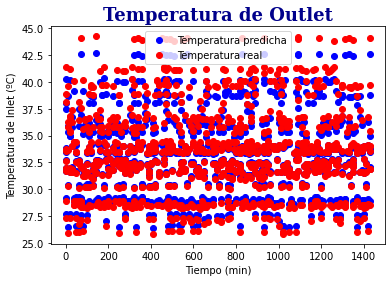

Entrenamiento con el 50.0% de los datos
<class 'float'>
(1045323, 37)
(522662, 37)
Epoch 1/5
7716/7716 [==============================] - 621s 79ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 2/5
7716/7716 [==============================] - 606s 79ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/5
7716/7716 [==============================] - 623s 81ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 4/5
7716/7716 [==============================] - 631s 82ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 5/5
7716/7716 [==============================] - 625s 81ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Evaluate on test data
1900/1900 [==============================] - 131s 68ms/step - loss: 0.0010 - mean_squared_error: 0.0010
test loss, test acc: [0.0010271203937008977, 0.0010271203937008977]
7599/7599 - 218s


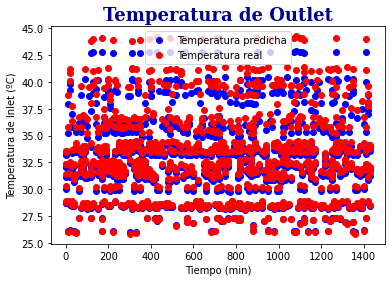

In [12]:
#Funcion para el estudio de reducir mediciones en el centro de datos
#tipo: el tipo de temperatura ("inlet" u "outlet")
def GRURandomData(tipo):
  global xin_test
  global xout_test
  global yin_test
  global yout_test
  global predictions
  global model
  global df
  #Los porcentajes de datos a testear
  coefs = [0.9, 0.75, 0.66, 0.5]

  if tipo == "inlet":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    xin_testm = x_test.loc[x_test.Inlet == 1.0].copy()
    yin_testm = y_test.loc[x_test.Inlet == 1.0].copy()
    del(xin_testm['Inlet'])
    del(xin_testm['Outlet'])
    del(xin_testm['Return'])
    times = xin_testm['time']
    del(xin_testm['time'])
    xin_testt = np.array(xin_testm)
    yin_testpp = np.array(yin_testm)
    xin_testpp = np.expand_dims(xin_testt, axis=-1)
  

  elif tipo == "outlet":
    preparacionDataFrame()
    separationTestData(0.33)
    preparacionInputGRU()
    xout_testm = x_test.loc[x_test.Outlet == 1.0].copy()
    yout_testm = y_test.loc[x_test.Outlet == 1.0].copy()
    del(xout_testm['Inlet'])
    del(xout_testm['Outlet'])
    del(xout_testm['Return'])
    times = xout_testm['time']
    del(xout_testm['time'])
    xout_testt = np.array(xout_testm)
    yout_testpp = np.array(yout_testm)
    xout_testpp = np.expand_dims(xout_testt, axis=-1)

  for i in coefs:
    print("Entrenamiento con el "+str(i*100)+"% de los datos")
    preparacionDataFrame()
    selecRandomData(i, 1)
    separationTestData(0.33)
    preparacionInputGRU()
    if tipo == "inlet":
      entrenamientoInlet(xin_testpp, yin_testpp)
      predecir(1, xin_testpp, yin_testpp, "Inlet")
    elif tipo == "outlet":
      entrenamientoOutlet(xout_testpp, yout_testpp)
      predecir(1, xout_testpp, yout_testpp, "Outlet")

GRURandomData("outlet")